In [37]:
# Install necessary packages if not installed
!pip install pandas numpy statsmodels matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [38]:
df = pd.read_csv('us-airlines-monthly-aircraft-miles-flown.csv', parse_dates=['Month'], index_col='Month')
df

,MilesMM
Month,
1963-01-01,6827
1963-02-01,6178
1963-03-01,7084
1963-04-01,8162
1963-05-01,8462
...,...
1970-08-01,14057
1970-09-01,16234
1970-10-01,12389


In [39]:
# rename column for clarity
df.rename(columns={'Passengers':'Miles_Flown'}, inplace=True)
df

,MilesMM
Month,
1963-01-01,6827
1963-02-01,6178
1963-03-01,7084
1963-04-01,8162
1963-05-01,8462
...,...
1970-08-01,14057
1970-09-01,16234
1970-10-01,12389


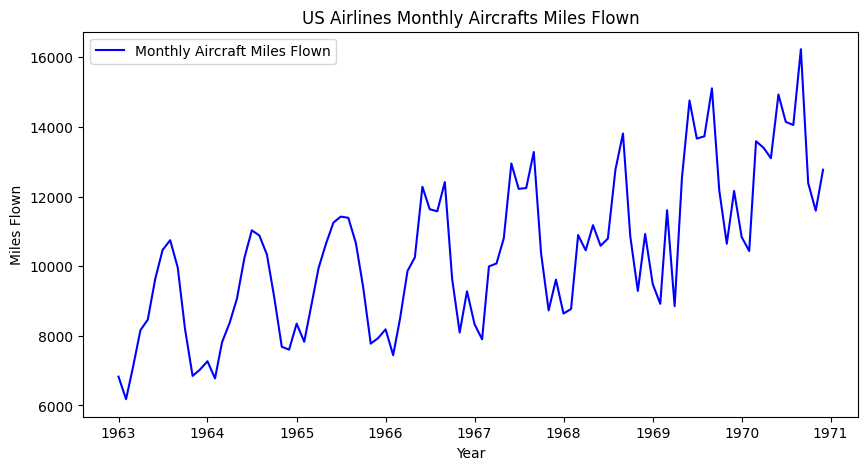

In [40]:
# plot the time series data
plt.figure(figsize=(10,5))
plt.plot(df, label='Monthly Aircraft Miles Flown', color='blue')
plt.xlabel('Year')
plt.ylabel('Miles Flown')
plt.title("US Airlines Monthly Aircrafts Miles Flown")
plt.legend()
plt.show()

In [41]:
# Check for the stationary usinf ADF Test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-values:", result[1])
    if result[1] <= 0.05:
        print("Data is Stationary")
    else:
        print("Data is not Stationary")

In [42]:
adf_test(df['MilesMM'])

ADF Statistic: 1.0229489778119754
p-values: 0.9945022811234028
Data is not Stationary


In [43]:
# Differencing to remove trend and seasonality
df['MilesMM_diff'] = df['MilesMM'].diff().dropna()
df['MilesMM_seasonal_diff'] = df['MilesMM'].diff(12).dropna()

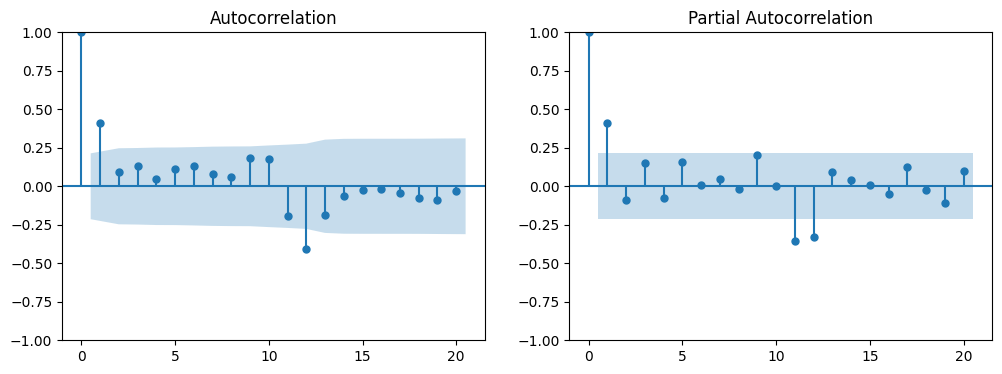

In [15]:
# plot ACF and PACF to identify parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['MilesMM_seasonal_diff'].dropna(), ax=axes[0])
plot_pacf(df['MilesMM_seasonal_diff'].dropna(), ax=axes[1])
plt.show()

In [16]:
# Define SARIMA Model (SARIMA(p,d,q)(P,D,Q,m))
p, d, q = 1, 1, 1  #ARIMA model
P, D, Q, m = 1, 1, 1, 12   # Seasonal order

In [23]:
# fit the SARIMA model 
sarima_model = sm.tsa.statespace.SARIMAX(df['MilesMM'],
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, m),
                                        enforce_stationary=False,
                                        enforce_invertibility=False)


D:\anconda\envs\notebook-6.5.7\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\anconda\envs\notebook-6.5.7\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
sarima_result = sarima_model.fit()

In [25]:
# Model Summary
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            MilesMM   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -668.828
Date:                            Tue, 01 Apr 2025   AIC                           1347.656
Time:                                    15:39:33   BIC                           1359.751
Sample:                                01-01-1963   HQIC                          1352.515
                                     - 12-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1880      0.131      1.440      0.150      -0.068       0.444
ma.L1         -0.8253      0.097   

In [30]:
# Forecasting for next 24 months
future_steps = 24
forecast = sarima_result.get_forecast(steps=future_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='M')[1:]
forecast_index

C:\Users\Dell\AppData\Local\Temp\ipykernel_14332\1156948135.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='M')[1:]


DatetimeIndex(['1971-01-31', '1971-02-28', '1971-03-31', '1971-04-30',
               '1971-05-31', '1971-06-30', '1971-07-31', '1971-08-31',
               '1971-09-30', '1971-10-31', '1971-11-30', '1971-12-31',
               '1972-01-31', '1972-02-29', '1972-03-31', '1972-04-30',
               '1972-05-31', '1972-06-30', '1972-07-31', '1972-08-31',
               '1972-09-30', '1972-10-31', '1972-11-30', '1972-12-31'],
              dtype='datetime64[ns]', freq='ME')

In [31]:
# COnfidence interval
forecast_ci = forecast.conf_int()
forecast_ci

,lower MilesMM,upper MilesMM
1971-01-01,10181.560815,13034.656228
1971-02-01,9699.703881,12734.606145
1971-03-01,12437.418605,15550.392370
1971-04-01,11150.494772,14326.289276
1971-05-01,12646.169022,15881.241910
1971-06-01,14331.340359,17624.200502
1971-07-01,13515.283078,16864.855453
1971-08-01,13711.365761,17116.691555
1971-09-01,15331.212537,18791.390846
1971-10-01,11999.536396,15513.710639


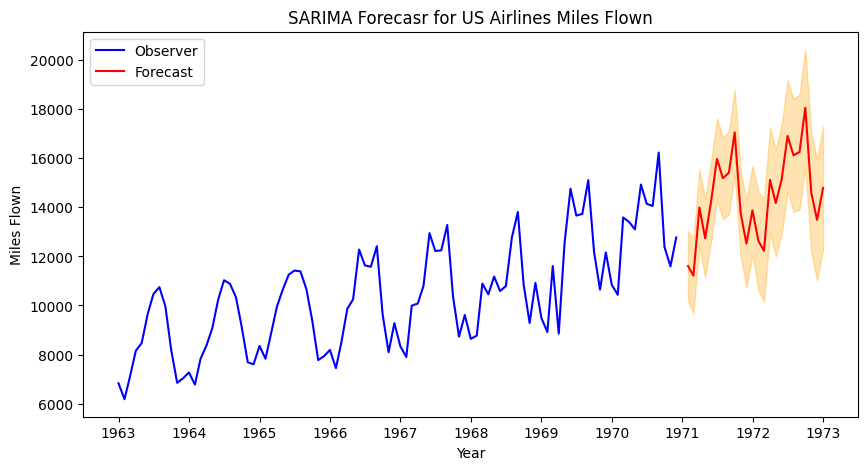

In [34]:
# plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['MilesMM'], label='Observer', color='blue')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='orange', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Miles Flown')
plt.title('SARIMA Forecasr for US Airlines Miles Flown')
plt.legend()
plt.show()